# Allen-Cahn Equation

This notebook implements a PIGP for the Allen-Cahn equation as described in the [DeepXDE documentation](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/allen.cahn.html)

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ["JAX_PLATFORM_NAME"] = "cpu"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [52]:
import jax.numpy as jnp
from jax import config, random

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys

sys.path.append("../../")

import jax_pigp
from jax_pigp.utility_fns import (
    softplus,
    generate_params,
    PARAM_OPTIONS_DICT as param_gen_options,
)
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True)

### Specify settings of the experiments

Ensure that this cell is tagged as "parameters" when using papermill

In [ ]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 2061

# true value of the viscosity parameter theta
THETA_TRUE: Array = jnp.array([0.001])

# initial value of theta from which to start training
THETA_INIT: Array = jnp.array([0.1])

# Set to true to consider inverse problem of identifying theta
RUN_INVERSE: bool = True

GP_TYPE: str = "pigp"  # psgp not supported for this example

# Number of PDE/ISC collocation points to use for inference
N_OBSERVATIONS: int = 500
Nu: int = N_OBSERVATIONS
Nf: int = N_OBSERVATIONS
# no symmetry information available for this example so we do not specify Ng

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# path to directory where data is saved
data_save_dir: str = f"allenCahnEquation"
data_save_dir_full = os.path.join("data", data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# initial value for std of noise levels in each space
NOISE_INIT: float = 0.1

# number of sub-linear differential operators required in specification
# of F, the algebraic representation of the PDE. In this case, we have
# two: Lf0 and Lf1, which are specified below
N_Lf: int = 2

# formula for calculating the dimensionality of the latent vector h
Nh: int = Nu + N_Lf * Nf
## Note: see Section 3.1 for a description of h

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = False

# options for model training
N_TRAIN_STEPS: int = 25000
N_RESTARTS: int = 1
LR_INIT: float = 5e-3
VERBOSE: bool = True

### Specify mean and kernel functions

These are designed such that the GP exactly satisfies the initial condition at $t=0$ and spatial boundary conditions at $x=-1/1$. These conditions are (see again the [DeepXDE documentation](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/allen.cahn.html) for full details):

$$u(x,0)  = x^2 \cos (\pi x) \quad \forall \quad x \in [-1,1],$$

and

$$u(-1,t) = u(1,t) = -1. \quad \forall \quad t>0.$$


In [19]:
# lower and upper boundaries of the spatio-temporal domain
lb: Array = jnp.array([-1.0, 0.0])
ub: Array = jnp.array([1.0, 1.0])


def mean_fn(p_: dict, loc: Array):
    x, _ = loc
    return (x**2) * jnp.cos(jnp.pi * x)


base_kernel = jax_pigp.kernels.rational_quadratic


def phi(loc: Array):
    x, t = loc
    return (ub[0] - x) * (x - lb[0]) * t


def kernel_fn(params: dict, loc1: Array, loc2: Array):

    base_kernel_val = base_kernel(params, loc1, loc2)

    adjust_val = phi(loc1) * phi(loc2)

    return (adjust_val * base_kernel_val).squeeze()

### Specify linear differential operators

The Allen-Cahn PDE we consider takes the form

$$PDE[u] =  \frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} - 5(u-u^3) = f = 0$$

In shorthand notation, the PDE reads

$$PDE[u] = u_{t} - \theta u_{xx}- 5(u - u^3) = f = 0.$$

Consider the following two functions, each of which is found by applying a linear operator to $u$:

\begin{align}
d_0 &= \mathcal{L}_0^f u = u \\
d_1 &= \mathcal{L}_1^f u = u_{t} - \theta u_{xx}
\end{align}

We can use these functions to represent the PDE in algebraic form as

\begin{equation}
F(d_0, d_1) = d_1 - 5(d_0 - d_0^3) = 0.
\end{equation}

See Section 2.2 of the manuscript for further details of the functions $d_0$, $d_1$ and $F$. These functions allow us to specify a virtual likelihood (see Eq. (16)) in the GP model.


##### Implementation: 
* We define a dummy linear operator for $u$-space data which is just the identity transformation
* $d_0$ is returned by calling the ``apply_Lf1`` function defined below
* $F(d_0, d_1)$ is implemented in the function ``F``


In [20]:
def apply_Identity(fn: Callable, argnum: int = 1):
    return fn


apply_Lf0 = apply_Identity


def apply_Lf1(fn: Callable, argnum: int = 1):
    r"""
    Applies Lf1 to given input input fn,
    evaluated at specified argnum
    """

    # the Jacobian and Hessian functions
    Jfn, Hfn = jac_hess(fn, argnum)

    def Lf1(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal
        ## value in loc1 / loc2

        theta = THETA_TRANSFORM(params["theta"])[0] if RUN_INVERSE else THETA_TRUE[0]

        _, ut_val = Jfn(params, loc1, *loc2)

        uxx_val = Hfn(params, loc1, *loc2)[0, 0]

        return ut_val - theta * uxx_val

    return Lf1


# dummy identity operator for u-space observations always comes before
# operators associated with the PDE
linear_operators = [apply_Identity, apply_Lf0, apply_Lf1]

# here 0 represents u-space (i.e. solution space) observations,
# while 1 represents f-space (i.e. PDE) observations.
# If we had g-space (i.e. ISC) observations,
# then another indicator = 2 would be required.
Xtrain_indices = [0, 1, 1]


def F(params: dict, d: Array):
    r"""
    Algebraic representation of the PDE
    """
    # N_Lf is equal to the length of the vector d here
    d0, d1 = d
    return d1 - 5.0 * (d0 - d0**3)

### Store settings

Store optimisation options in a dictionary

In [21]:
opt_options = {}
opt_options["n_steps"] = N_TRAIN_STEPS
opt_options["n_restarts"] = N_RESTARTS
opt_options["lr"] = LR_INIT
opt_options["verbose"] = VERBOSE
opt_options["theta_transform"] = THETA_TRANSFORM
opt_options["noise_transform"] = NOISE_TRANSFORM

In [22]:
param_gen_options["ls_bounds"] = [0.25, 1.]
param_gen_options["amp_bounds"] = [.25, 1.]
param_gen_options["alpha_bounds"] = [.25, 1.]
param_gen_options["input_dim"] = INPUT_DIM
param_gen_options["theta_init"] = THETA_INIT
param_gen_options["theta_transform"] = THETA_TRANSFORM
# each function space (u/f/g spaces) gets its own noise level
param_gen_options["noise_std_init"] = [NOISE_INIT]*3
param_gen_options["noise_transform"] = NOISE_TRANSFORM
param_gen_options["nonlinear"] = True
param_gen_options["Nh"] = Nh

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [8]:
results_save_dir = os.path.join("results", data_save_dir, f"{GP_TYPE}_Nu_{Nu}_Nf_{Nf}")
if not os.path.isdir(results_save_dir):
    os.makedirs(results_save_dir)

## Data and model initialisation

#### Load train and test data

In [9]:
train_data, test_data = load_data_nonlinear(data_save_dir_full, Nu, Nf)

Check shapes of train and test data

In [10]:
test_data.us.shape, [X.shape for X in train_data.Xtrain]

((20301, 1), [(500, 2), (500, 2)])

#### Initialise PIGP model

In [11]:
fisher_like_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(
    kernel_fn, linear_operators, Xtrain_indices
)
fisher_like_mean_fns = jax_pigp.interdomain_moments.InterdomainMeanFns(
    mean_fn, linear_operators, Xtrain_indices
)

gp_model = jax_pigp.models.PSGP(fisher_like_kernel_fns, fisher_like_mean_fns, F, N_Lf)

#### Initialise learner for model training

In [12]:
obj_fn_train = lambda params: -gp_model.elbo(params, train_data)

gp_learner = jax_pigp.optimisers.AdamLearner(
    obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL)
)

Initial parameter values  

In [13]:
print_param_values(gp_learner.params, opt_options)

amp: [0.4452853]
ls: [0.71091066 0.77262688]
alpha: [0.53278049]
noise_std: [0.1 0.1 0.1]
theta: [0.1]


Objective function value for inital parameters

In [14]:
gp_model.elbo(gp_learner.params, train_data)

Array(-56945.90176341, dtype=float64)

Gradient of the objective function wrt to inital parameters

In [15]:
# gp_learner.grad_obj_fn(gp_learner.params)

## Training 

JIT compile the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [17]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [46]:
print(
    f"gp_type={GP_TYPE}, Nu={Nu}, Nf={Nf}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n"
)
gp_learner.train_with_restarts(
    opt_options["n_steps"],
    opt_options["n_restarts"],
    print_progress=opt_options["verbose"],
)

Uncomment below to continue training from existing parameter values:

In [45]:
# gp_learner.train(opt_options["n_steps"], n_print_steps=250)

### Plot training results

In [51]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=TWO_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list) * 0.05)

plot_lc(axes[0], gp_learner.obj_list[begin_at:], "Objective Function")
plot_lc(axes[1], theta_arr[begin_at:, 0], "theta")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "learningCurves.pdf"))

### Final trained parameter values

In [48]:
# extract final trained parameter values
try:
    trained_params = gp_learner.params_best.copy()
    print(f'set trained_params to gp_learner.params_best\n')
except:
    trained_params = gp_learner.params.copy()
    print(f'set trained_params to gp_learner.params\n')

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, "trained_params.pkl"), "wb") as fp:
    pickle.dump(trained_params, fp)

set trained_params to gp_learner.params

alpha: [0.21520841]
amp: [0.50584011]
ls: [0.11415427 0.63964281]
noise_std: [0.00078188 0.01408943 0.1       ]
theta: [0.0010087]


Can load pre-trained parameters by uncommenting the below

In [35]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [49]:
# posterior mean and covariance over test points
print(
    f"Posterior results for {GP_TYPE}, Nu={train_data.Xtrain[0].shape[0]}, Nf={train_data.Xtrain[1].shape[0]}, Ns={test_data.Xs.shape[0]}"
)
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)
s = jnp.diag(Sigma) ** 0.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, "u_pred.npy"), mu)
    jnp.save(os.path.join(results_save_dir, "s_pred.npy"), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f"mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}")
savetxt(
    os.path.join(results_save_dir, "mean_loss.txt"), abs_losses.mean().reshape(-1, 1)
)

if RUN_INVERSE:
    theta_pred = opt_options["theta_transform"](trained_params["theta"])
    theta_loss = jnp.linalg.norm(theta_pred - THETA_TRUE)
    print(f"theta_true : {THETA_TRUE}")
    print(f"theta_pred : {theta_pred}")
    print(f"theta_loss : {theta_loss:.3e}")
    savetxt(os.path.join(results_save_dir, "theta_loss.txt"), jnp.array([theta_loss]))

Posterior results for pigp, Nu=500, Nf=500, Ns=20301
mean/max loss: 5.657229e-04/4.082e-02
theta_true : [0.001]
theta_pred : [0.0010087]
theta_loss : 8.700e-06


#### Plots of posterior prediction

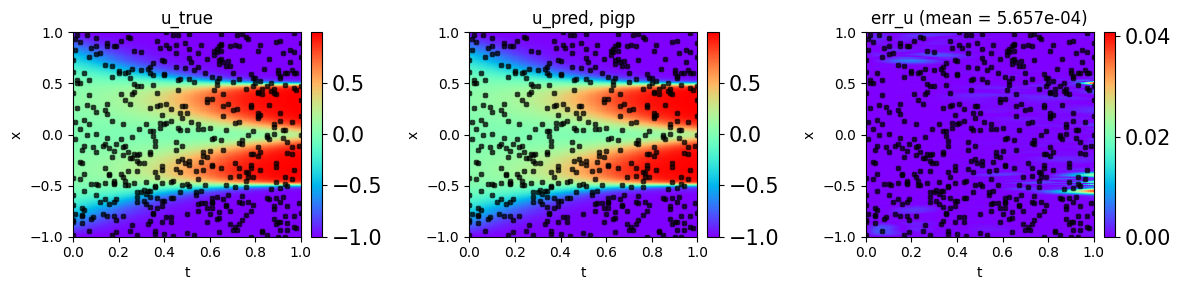

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=THREE_COLUMN_FIGSIZE)

Nx = len(jnp.unique(test_data.Xs[:, 0]))
Nt = len(jnp.unique(test_data.Xs[:, 1]))

Xu, Xf = train_data.Xtrain

make_heatmap_ac = lambda ax, output, title=None: make_heatmap(
    fig, ax, output.reshape(Nt, Nx).T, test_data, Xu, Xf, title
)

make_heatmap_ac(axes[0], test_data.us, title="u_true")
make_heatmap_ac(axes[1], mu, title=f"u_pred, {GP_TYPE}")
make_heatmap_ac(axes[2], abs_losses, title=f"err_u (mean = {abs_losses.mean():.3e})")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "posteriorPrediction.pdf"))